# Multiband forced photometry using tractor
### IRAC & Galex
### Including multiprocessing



In [1]:
import math
import time
import warnings
import concurrent.futures

import sys
import os
from contextlib import contextmanager

import numpy as np

try:
    import pandas as pd
except ImportError:
    !{sys.executable} -m pip install -U pandas

import pandas as pd

import matplotlib.pyplot as plt

try:
    import seaborn as sns
except ImportError:
    !{sys.executable} -m pip install -U seaborn
    
import seaborn as sns

try: 
    import statsmodels
except ImportError:
    !{sys.executable} -m pip install -U statsmodels
import statsmodels

from astropy.nddata import Cutout2D
from astropy.stats import sigma_clipped_stats
import astropy.wcs as wcs
import astropy.io.fits as fits
from astropy.table import Table
from astroquery.ipac.irsa import Irsa
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.heasarc import Heasarc

try:
    import nwaylib.fastskymatch as fastskymatch
except ImportError:
    !{sys.executable} -m pip install -U nway


import nwaylib.fastskymatch as fastskymatch
import nwaylib.bayesdistance as bayesdistance
import nwaylib.checkupdates as checkupdates
import nwaylib.magnitudeweights as magnitudeweights
import nwaylib.progress as nwayprogress

Irsa.ROW_LIMIT = 1E6

from skimage.transform import rotate

from tractor import (Tractor, PointSource, PixPos, Flux, PixelizedPSF, NullWCS,
                     NullPhotoCal, ConstantSky, Image)


sys.path.append('../code/')
from determine_source_type import determine_source_type
from extract_cutout import extract_cutout
from find_nconfsources import find_nconfsources
from display_images import display_images
from plot_SED import plot_SED
from nway_write_header import nway_write_header
#from prepare_prf import prepare_prf

set up clean catalog with fiducial band fluxes, ra, dec, shape parameters, probability that it is a star

In [2]:
#pull a COSMOS catalog from IRSA using astroquery
#coords = SkyCoord('10h00m28.6s +02d12m21.0s', frame='icrs')  #COSMOS center acording to Simbad
coords = SkyCoord('150.01d 2.2d', frame='icrs')  #COSMOS center acording to Simbad

rad_in_arcmin = 3
cosmos_table = Irsa.query_region(coords, catalog = "cosmos2015",  radius = rad_in_arcmin*u.arcmin,selcols='ra,dec,id,Ks_FLUX_APER2,Ks_FLUXERR_APER2, SPLASH_1_FLUX, SPLASH_1_FLUX_ERR,SPLASH_2_FLUX, SPLASH_2_FLUX_ERR,SPLASH_3_FLUX, SPLASH_3_FLUX_ERR,SPLASH_4_FLUX, SPLASH_4_FLUX_ERR, FLUX_GALEX_NUV,FLUX_GALEX_FUV,FLUX_CHANDRA_05_2,FLUX_CHANDRA_2_10, FLUX_CHANDRA_05_10,ID_CHANDRA09 , type ')

#select those rows with either chandra fluxes or Galex NUV fluxes
ccosmos_table = cosmos_table[(cosmos_table['flux_chandra_05_10']> 0) | (cosmos_table['flux_galex_fuv'] > 0)]
ccosmos_table

#convert to pandas
df = ccosmos_table.to_pandas()



In [3]:
#are there missing values
df.isna().sum()

#don't mind that there are missing values for IRAC flues or for photzs.  
#The rest of the rows are complete

ra                      0
dec                     0
clon                    0
clat                    0
id                      0
ks_flux_aper2           2
ks_fluxerr_aper2        2
splash_1_flux           6
splash_1_flux_err       6
splash_2_flux           3
splash_2_flux_err       3
splash_3_flux          21
splash_3_flux_err      21
splash_4_flux           1
splash_4_flux_err       1
flux_galex_nuv         89
flux_galex_fuv         13
flux_chandra_05_2     461
flux_chandra_2_10     461
flux_chandra_05_10    461
id_chandra09          461
type                    0
dist                    0
angle                   0
dtype: int64

In [4]:
#ot of curiosity how many stars vs. galaxies vs. x ray sources
df.type.value_counts()

 0    448
 2     19
 1     12
-9      2
Name: type, dtype: int64

In [5]:
# initialize columns in data frame for photometry results
df[["ch1flux","ch1flux_unc","ch2flux","ch2flux_unc","ch3flux","ch3flux_unc","ch4flux","ch4flux_unc","ch5flux","ch5flux_unc","ch6flux","ch6flux_unc"]] = 0.0
df

,ra,dec,clon,clat,id,ks_flux_aper2,ks_fluxerr_aper2,splash_1_flux,splash_1_flux_err,splash_2_flux,...,ch2flux,ch2flux_unc,ch3flux,ch3flux_unc,ch4flux,ch4flux_unc,ch5flux,ch5flux_unc,ch6flux,ch6flux_unc
0,150.008936,2.197367,10h00m02.14s,02d11m50.52s,591483,23.305,0.218,22.961,0.296,23.234,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,150.009852,2.204067,10h00m02.36s,02d12m14.64s,593975,0.409,0.216,0.552,0.056,0.523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,150.006743,2.203549,10h00m01.62s,02d12m12.78s,594361,1.318,0.217,1.570,0.052,1.066,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,150.014884,2.203001,10h00m03.57s,02d12m10.80s,594586,3.545,0.217,4.376,0.109,3.252,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,150.011286,2.193494,10h00m02.71s,02d11m36.58s,587391,3.762,0.219,5.114,0.061,3.593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,150.050676,2.228801,10h00m12.16s,02d13m43.68s,611408,1.166,0.089,1.252,0.045,0.902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
477,149.960112,2.201306,09h59m50.43s,02d12m04.70s,595713,106.181,0.216,95.230,0.344,95.827,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
478,149.998366,2.248500,09h59m59.61s,02d14m54.60s,626476,28.059,0.201,33.102,0.260,32.923,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
479,150.058493,2.187916,10h00m14.04s,02d11m16.50s,583865,4.809,0.099,7.073,0.083,6.615,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#setup to supress output of tractor
#seems to be the only way to make it be quiet and not output every step of optimization
#https://stackoverflow.com/questions/2125702/how-to-suppress-console-output-in-python

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout


In [7]:
# parameters needed for the next function

#IRAC
irac_fluxconversion = (1E12) / (4.254517E10) * (0.6) *(0.6) #convert tractor result to microjanskies
mosaic_pix_scale_irac = 0.6
cutout_width_irac = 10 # set default cutout width = 10"

#Galex
cutout_width_GALEX = 40
GALEX_nuv_fluxconversion= 3.373E1 * 1000#uJy  fudging this to make the numbers bigger for plotting later
GALEX_fuv_fluxconversion=1.076E2 * 1000 #uJy fudging this to make the numbers bigger for plotting later


mosaic_pix_scale_GALEX = 1.5

cutout_width_list=[cutout_width_irac,cutout_width_irac,cutout_width_irac,cutout_width_irac,cutout_width_GALEX,cutout_width_GALEX]
flux_conv_list=[irac_fluxconversion,irac_fluxconversion,irac_fluxconversion,irac_fluxconversion,GALEX_nuv_fluxconversion,GALEX_fuv_fluxconversion]
mosaic_pix_scale_list=[mosaic_pix_scale_irac,mosaic_pix_scale_irac,mosaic_pix_scale_irac,mosaic_pix_scale_irac,mosaic_pix_scale_GALEX,mosaic_pix_scale_GALEX]

#GALEX MASTER PSFs
prf_nuv = fits.open("../data/Galex/PSFnuv_faint.fits")[0].data
prf_fuv= fits.open("../data/Galex/PSFfuv.fits")[0].data
prf_nuv=prf_nuv[0:119, 0:119]
prf_fuv=prf_fuv[0:119, 0:119]
#these are much larger than the cutouts we are using, so only keep the central region which is the size of our cutouts
ngalex_pix = cutout_width_GALEX / mosaic_pix_scale_GALEX
prf_cen = int(60)
prf_nuv = prf_nuv[(prf_cen - int(ngalex_pix / 2) - 1) : (prf_cen + int(ngalex_pix / 2)), (prf_cen - int(ngalex_pix / 2) - 1) : (prf_cen + int(ngalex_pix / 2))]
prf_fuv = prf_fuv[(prf_cen - int(ngalex_pix / 2) - 1) : (prf_cen + int(ngalex_pix / 2)), (prf_cen - int(ngalex_pix / 2) - 1) : (prf_cen + int(ngalex_pix / 2))]


#set up prfs for each channel
prfs = [fits.open('../data/IRAC/PRF_IRAC_ch1.fits')[0].data,
        fits.open('../data/IRAC/PRF_IRAC_ch2.fits')[0].data,
        fits.open('../data/IRAC/PRF_IRAC_ch3.fits')[0].data,
        fits.open('../data/IRAC/PRF_IRAC_ch4.fits')[0].data, prf_nuv, prf_fuv]
    
#set up mosaics for each channel
infiles = ['../data/IRAC/COSMOS_irac_ch1_mosaic_recenter.fits',
           '../data/IRAC/COSMOS_irac_ch2_mosaic_recenter.fits',
           '../data/IRAC/COSMOS_irac_ch3_mosaic_recenter.fits',
           '../data/IRAC/COSMOS_irac_ch4_mosaic_recenter.fits',
           '../data/Galex/0001_150.01000000_2.20000000_COSMOS_01-nd-int.fits',
           '../data/Galex/0001_150.01000000_2.20000000_COSMOS_01-fd-int.fits']

#read in those mosaics only once here instead of inside the function
hdulists = [fits.open(infiles[0])[0], fits.open(infiles[1])[0],fits.open(infiles[2])[0],fits.open(infiles[3])[0],fits.open(infiles[4])[0],fits.open(infiles[5])[0]]
headers = [hdulists[0].header,hdulists[1].header,hdulists[2].header,hdulists[3].header,hdulists[4].header,hdulists[5].header]

#grab the WCS of the mosaics
wcs_infos = [wcs.WCS(hdulists[0]),wcs.WCS(hdulists[1]),wcs.WCS(hdulists[2]),wcs.WCS(hdulists[3]),wcs.WCS(hdulists[4]),wcs.WCS(hdulists[5])]


In [8]:
def calc_instrflux(band, ra, dec, stype, ks_flux_aper2):
    """
    calculate instrumental fluxes and uncertainties for four IRAC bands 
    
    Parameters:
    -----------
    band: int
        integer in [0, 1, 2, 3] for the four IRAC bands
    ra, dec: float or double
        celestial coordinates for measuring photometry
    stype: int
        0, 1, 2 for star, galaxy, x-ray source
    ks_flux_aper_2: float
        flux in aperture 2
        
    Returns:
    --------
    outband: int
        reflects input band for identification purposes
    flux: float
        measured flux in microJansky, NaN if unmeasurable
    unc: float
        measured uncertainty in microJansky, NaN if not able to estimate
    """
    prf = prfs[band]
    infile = infiles[band]
    hdr = headers[band]
    cutout_width=cutout_width_list[band]
    mosaic_pix_scale=mosaic_pix_scale_list[band]
    flux_conv=flux_conv_list[band]
    
    #make a cutout
    subimage, nodata_param, x1, y1, subimage_wcs = extract_cutout(ra, dec,cutout_width, mosaic_pix_scale, hdulists[band], wcs_infos[band])
    
    #catch errors in making the cutouts
    if nodata_param == False:  #meaning we have data in the cutout
        
        #set up the source list
        #src = determine_source_type(df.ra[i], df.dec[i], df.type[i], df.ks_flux_aper2[i], x1,y1)
        objsrc, nconfsrcs = find_nconfsources(ra, dec, stype,
                        ks_flux_aper2, x1,y1, cutout_width, subimage_wcs, df)

        #measure sky noise and mean level
        skymean, skymedian, skynoise = sigma_clipped_stats(subimage, sigma=3.0)
        
        #make the tractor image
        tim=Image(data=subimage, invvar=np.ones_like(subimage) / skynoise**2, 
              psf=PixelizedPSF(prf) ,
              wcs=NullWCS(),photocal=NullPhotoCal(),sky=ConstantSky(skymean))
               
        # make tractor object
        tractor=Tractor([tim], objsrc) #[src]

        #freeze the parameters we don't want tractor fitting
        tractor.freezeParam('images') #now fits 2 positions and flux
        #only fit for flux
        #src.freezeAllRecursive()
        #src.thawPathsTo('brightness')


        #run the tractor optimization (do forced photometry)
        # Take several linearized least squares steps
        fit_fail = False
        try:
            tr = 0
            with suppress_stdout():
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore', '.*divide by zero.*')
                    #warnings.simplefilter('ignore')
                    for tr in range(20):
                        dlnp,X,alpha, flux_var=tractor.optimize(variance = True)
                        #print('dlnp',dlnp)
                        if dlnp < 1e-3:
                            break
        # catch exceptions and bad fits
        except:
            fit_fail = True
            
        # record the photometry results
        if fit_fail: 
            #tractor fit failed
            #set flux and uncertainty as nan and move on
            return(band, np.nan, np.nan)
        elif flux_var is None:  
            #fit worked, but flux variance did not get reported
            params_list=objsrc[0].getParamNames()
            bindex = params_list.index('brightness.Flux')
            flux = objsrc[0].getParams()[bindex]
             #convert to microjanskies
            microJy_flux = flux * flux_conv
            return(band, microJy_flux, np.nan)
        else: 
            #fit and variance worked
            params_list=objsrc[0].getParamNames()
            bindex = params_list.index('brightness.Flux')
            flux = objsrc[0].getParams()[bindex]
                
            # determine flux uncertainty
            #which value of flux_var is for the flux variance?
            fv = ((nconfsrcs+1)*3) - 1  #assumes we are fitting positions and flux
            tractor_std = np.sqrt(flux_var[fv])  
                
            #convert to microjanskies
            microJy_flux = flux * flux_conv
            microJy_unc = tractor_std *flux_conv
            return(band, microJy_flux, microJy_unc)
        
    else:
        return(band, np.nan, np.nan)


Make a copy of the dataframe for the parallel calculation.

In [9]:
pl_df = df.copy(deep=True)

Run it on everything

In [10]:
%%time
t0 = time.time()
for row in df.itertuples():
    for band in range(6):
        outband, flux, unc = calc_instrflux(band, row.ra, row.dec, row.type, row.ks_flux_aper2)
        df.loc[row.Index, 'ch{:d}flux'.format(outband+1)] = flux
        df.loc[row.Index, 'ch{:d}flux_unc'.format(outband+1)] = unc
        #print(row.ra, row.dec, row.type, row.ks_flux_aper2, band+1,
        #      outband, flux, unc)
t1 = time.time()

/opt/conda/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:957: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:957: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, d

CPU times: user 4min 31s, sys: 170 ms, total: 4min 31s
Wall time: 4min 31s


Parallelization: we can either interate over the rows of the dataframe and run the four bands in parallel; or we could zip together the row index, band, ra, dec, 

In [11]:
paramlist = []
for row in df.itertuples():
    for band in range(6):
        paramlist.append([row.Index, band, row.ra, row.dec, row.type, row.ks_flux_aper2])

In [12]:
print(len(paramlist))

2886


In [13]:
calc_instrflux(paramlist[0][1], paramlist[0][2], paramlist[0][3], paramlist[0][4], paramlist[0][5])

(0, 65.70230114810185, 0.6016211444422599)

In [14]:
calc_instrflux(*paramlist[0][1:])

(0, 65.70230114810185, 0.6016211444422599)

In [15]:
def calculate_flux(args):
    """Calculate flux."""
    f = calc_instrflux
    val = f(*args[1:])
    return(args[0], val)

In [16]:
%%time
t2 = time.time()
outputs = []
with concurrent.futures.ProcessPoolExecutor(24) as executor:
    for result in executor.map(calculate_flux, paramlist):
        # print(result)
        pl_df.loc[result[0],
                  'ch{:d}flux'.format(result[1][0] + 1)] = result[1][1]
        pl_df.loc[result[0],
                  'ch{:d}flux_unc'.format(result[1][0] + 1)] = result[1][1]
        outputs.append(result)
t3 = time.time()

/opt/conda/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:957: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.8/site-packages/astropy/stats/sigma_clipping.py:957: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data_clipped, axis=axis)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, d

CPU times: user 4.61 s, sys: 1.82 s, total: 6.44 s
Wall time: 24 s


In [17]:
print('Serial calculation took {:.2f} seconds'.format((t1 - t0)))
print('Parallel calculation took {:.2f} seconds'.format((t3 - t2)))
print('Speedup is {:.2f}'.format((t1 - t0) / (t3 - t2)))

Serial calculation took 271.32 seconds
Parallel calculation took 24.01 seconds
Speedup is 11.30


Count the number of non-zero ch1 fluxes

In [18]:
print('Serial calculation: number of ch1 fluxes filled in =',
      np.sum(df.ch1flux > 0))
print('Parallel calculation: number of ch1 fluxes filled in =',
      np.sum(pl_df.ch1flux > 0))

Serial calculation: number of ch1 fluxes filled in = 124
Parallel calculation: number of ch1 fluxes filled in = 124


Continue with the rest of the notebook using the populated dataframe

In [19]:
#just checking that df is getting filled in properly
#rows with zero fluxes are likely outside the bounds of the mosaic
df

,ra,dec,clon,clat,id,ks_flux_aper2,ks_fluxerr_aper2,splash_1_flux,splash_1_flux_err,splash_2_flux,...,ch2flux,ch2flux_unc,ch3flux,ch3flux_unc,ch4flux,ch4flux_unc,ch5flux,ch5flux_unc,ch6flux,ch6flux_unc
0,150.008936,2.197367,10h00m02.14s,02d11m50.52s,591483,23.305,0.218,22.961,0.296,23.234,...,56.715365,0.599153,37.952269,1.667068,38.678776,2.834328,92.609230,5.038188,NaN,NaN
1,150.009852,2.204067,10h00m02.36s,02d12m14.64s,593975,0.409,0.216,0.552,0.056,0.523,...,-0.799495,0.221582,8.092680,1.150269,4.942110,1.730117,NaN,NaN,0.173761,1364.590835
2,150.006743,2.203549,10h00m01.62s,02d12m12.78s,594361,1.318,0.217,1.570,0.052,1.066,...,1.390821,0.227129,2.885986,1.120008,7.374467,1.787003,31.684028,879.752386,8.278584,8.860523
3,150.014884,2.203001,10h00m03.57s,02d12m10.80s,594586,3.545,0.217,4.376,0.109,3.252,...,12.869151,0.329346,9.546514,1.452241,9.006017,1.828653,72.774176,1602.797973,NaN,NaN
4,150.011286,2.193494,10h00m02.71s,02d11m36.58s,587391,3.762,0.219,5.114,0.061,3.593,...,2.546584,0.831598,2.858714,6.146573,3.887210,2.065788,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,150.050676,2.228801,10h00m12.16s,02d13m43.68s,611408,1.166,0.089,1.252,0.045,0.902,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
477,149.960112,2.201306,09h59m50.43s,02d12m04.70s,595713,106.181,0.216,95.230,0.344,95.827,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
478,149.998366,2.248500,09h59m59.61s,02d14m54.60s,626476,28.059,0.201,33.102,0.260,32.923,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
479,150.058493,2.187916,10h00m14.04s,02d11m16.50s,583865,4.809,0.099,7.073,0.083,6.615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#how many rows did get filled in?  = 225
df_fill = df[df.ch1flux > 0]
df_fill

,ra,dec,clon,clat,id,ks_flux_aper2,ks_fluxerr_aper2,splash_1_flux,splash_1_flux_err,splash_2_flux,...,ch2flux,ch2flux_unc,ch3flux,ch3flux_unc,ch4flux,ch4flux_unc,ch5flux,ch5flux_unc,ch6flux,ch6flux_unc
0,150.008936,2.197367,10h00m02.14s,02d11m50.52s,591483,23.305,0.218,22.961,0.296,23.234,...,56.715365,0.599153,37.952269,1.667068,38.678776,2.834328,92.609230,5.038188,NaN,NaN
1,150.009852,2.204067,10h00m02.36s,02d12m14.64s,593975,0.409,0.216,0.552,0.056,0.523,...,-0.799495,0.221582,8.092680,1.150269,4.942110,1.730117,NaN,NaN,0.173761,1364.590835
2,150.006743,2.203549,10h00m01.62s,02d12m12.78s,594361,1.318,0.217,1.570,0.052,1.066,...,1.390821,0.227129,2.885986,1.120008,7.374467,1.787003,31.684028,879.752386,8.278584,8.860523
3,150.014884,2.203001,10h00m03.57s,02d12m10.80s,594586,3.545,0.217,4.376,0.109,3.252,...,12.869151,0.329346,9.546514,1.452241,9.006017,1.828653,72.774176,1602.797973,NaN,NaN
4,150.011286,2.193494,10h00m02.71s,02d11m36.58s,587391,3.762,0.219,5.114,0.061,3.593,...,2.546584,0.831598,2.858714,6.146573,3.887210,2.065788,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,149.988951,2.222739,09h59m57.35s,02d13m21.86s,607181,0.836,0.215,0.897,0.057,0.748,...,-0.796307,0.191023,-1.675767,1.176202,-6.557229,1.873124,NaN,NaN,NaN,NaN
192,150.027417,2.174252,10h00m06.58s,02d10m27.31s,576828,28.117,0.145,42.233,0.268,32.275,...,9.305278,1.619941,-24.995286,27.266240,-19.451654,9.282248,518.586336,9462.862137,339.635527,5331.265001
214,149.983851,2.179139,09h59m56.12s,02d10m44.90s,577681,0.805,0.214,0.640,0.057,0.390,...,1873.153886,1351.911531,69.799645,919.958117,12.002114,198.806619,-542.244455,2380.205707,-2332.962040,1158.600327
240,150.036403,2.224184,10h00m08.74s,02d13m27.06s,607931,1.426,0.116,2.234,0.053,2.739,...,8.161577,42.365871,13.378788,206.696628,28.485521,26.284700,NaN,NaN,NaN,NaN


In [21]:
#how many rows did get filled in?  = 225
pl_df_fill = pl_df[pl_df.ch1flux > 0]
pl_df_fill

,ra,dec,clon,clat,id,ks_flux_aper2,ks_fluxerr_aper2,splash_1_flux,splash_1_flux_err,splash_2_flux,...,ch2flux,ch2flux_unc,ch3flux,ch3flux_unc,ch4flux,ch4flux_unc,ch5flux,ch5flux_unc,ch6flux,ch6flux_unc
0,150.008936,2.197367,10h00m02.14s,02d11m50.52s,591483,23.305,0.218,22.961,0.296,23.234,...,56.715365,56.715365,37.952269,37.952269,38.678776,38.678776,92.609230,92.609230,NaN,NaN
1,150.009852,2.204067,10h00m02.36s,02d12m14.64s,593975,0.409,0.216,0.552,0.056,0.523,...,-0.799495,-0.799495,8.092680,8.092680,4.942110,4.942110,NaN,NaN,0.173761,0.173761
2,150.006743,2.203549,10h00m01.62s,02d12m12.78s,594361,1.318,0.217,1.570,0.052,1.066,...,1.390821,1.390821,2.885986,2.885986,7.374467,7.374467,31.684028,31.684028,8.278584,8.278584
3,150.014884,2.203001,10h00m03.57s,02d12m10.80s,594586,3.545,0.217,4.376,0.109,3.252,...,12.869151,12.869151,9.546514,9.546514,9.006017,9.006017,72.774176,72.774176,NaN,NaN
4,150.011286,2.193494,10h00m02.71s,02d11m36.58s,587391,3.762,0.219,5.114,0.061,3.593,...,2.546584,2.546584,2.858714,2.858714,3.887210,3.887210,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,149.988951,2.222739,09h59m57.35s,02d13m21.86s,607181,0.836,0.215,0.897,0.057,0.748,...,-0.796307,-0.796307,-1.675767,-1.675767,-6.557229,-6.557229,NaN,NaN,NaN,NaN
192,150.027417,2.174252,10h00m06.58s,02d10m27.31s,576828,28.117,0.145,42.233,0.268,32.275,...,9.305278,9.305278,-24.995286,-24.995286,-19.451654,-19.451654,518.586336,518.586336,339.635527,339.635527
214,149.983851,2.179139,09h59m56.12s,02d10m44.90s,577681,0.805,0.214,0.640,0.057,0.390,...,1873.153886,1873.153886,69.799645,69.799645,12.002114,12.002114,-542.244455,-542.244455,-2332.962040,-2332.962040
240,150.036403,2.224184,10h00m08.74s,02d13m27.06s,607931,1.426,0.116,2.234,0.053,2.739,...,8.161577,8.161577,13.378788,13.378788,28.485521,28.485521,NaN,NaN,NaN,NaN


In [22]:
#had to call the galex flux columns ch5 and ch6
#fix that by renaming them now
df.rename(columns={'ch5flux':'nuvflux', 'ch5flux_unc':'nuvflux_unc','ch6flux':'fuvflux', 'ch6flux_unc':'fuvflux_unc'}, inplace = True)
pl_df.rename(columns={'ch5flux':'nuvflux', 'ch5flux_unc':'nuvflux_unc','ch6flux':'fuvflux', 'ch6flux_unc':'fuvflux_unc'}, inplace = True)

CPU times: user 1min 11s, sys: 1.94 s, total: 1min 13s
Wall time: 1min 11s


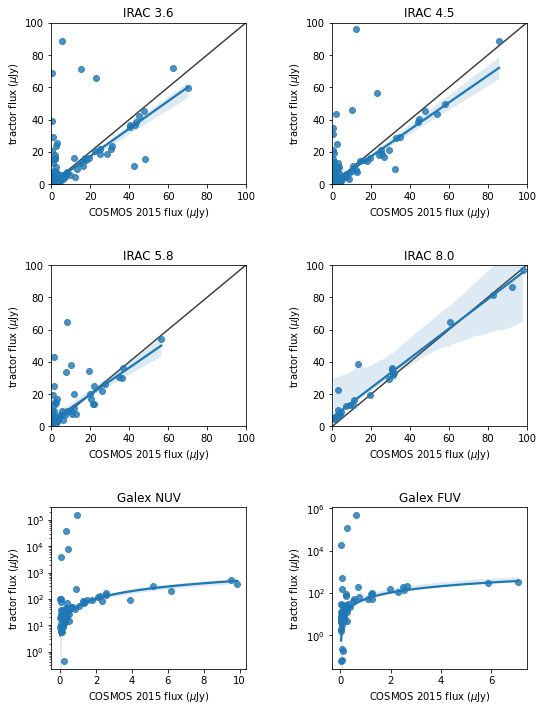

In [23]:
%%time
#plot tractor fluxes vs. catalog splash fluxes
#and hope I see a straightline with a slope of 1
#using sns regplot which plots both the data and a linear regression model fit
#this plotting tool is for visualization and not statistics, so I don't have rigorous slopes from it.
#need to still add uncertainties to the plotting and regression


#setup to plot
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6)) = plt.subplots(3, 2)
fluxmax = 200
ymax = 100
xmax = 100
#ch1 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[(df.splash_1_flux> 0) & (df.splash_1_flux < fluxmax)] #200
sns.regplot(data = df_tractor, x = "splash_1_flux", y = "ch1flux", ax = ax1, robust = True)#scatterplot
#add a diagonal line with y = x
lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax1.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 3.6')
ax1.set_ylim([0, ymax])
ax1.set_xlim([0, xmax])


#ch2 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[(df.splash_2_flux> 0) & (df.splash_2_flux < fluxmax)]
sns.regplot(data = df_tractor, x = "splash_2_flux", y = "ch2flux", ax = ax2, robust = True)
#add a diagonal line with y = x
lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax2.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 4.5')
ax2.set_ylim([0, ymax])
ax2.set_xlim([0, xmax])


#ch3 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[(df.splash_3_flux> 0) & (df.splash_3_flux < fluxmax)]

sns.regplot(data = df_tractor, x = "splash_3_flux", y = "ch3flux", ax = ax3, robust = True)
#add a diagonal line with y = x
lims = [
    np.min([ax3.get_xlim(), ax3.get_ylim()]),  # min of both axes
    np.max([ax3.get_xlim(), ax3.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax3.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax3.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 5.8')
ax3.set_ylim([0, ymax])
ax3.set_xlim([0, xmax])


#ch4 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[(df.splash_4_flux> 0) & (df.splash_4_flux < fluxmax)]

sns.regplot(data = df_tractor, x = "splash_4_flux", y = "ch4flux", ax = ax4, robust = True)
#add a diagonal line with y = x
lims = [
    np.min([ax4.get_xlim(), ax4.get_ylim()]),  # min of both axes
    np.max([ax4.get_xlim(), ax4.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax4.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax4.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 8.0')
ax4.set_ylim([0, ymax])
ax4.set_xlim([0, xmax])

#-------
#nuv 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[(df.flux_galex_nuv> 0) & (df.flux_galex_nuv < 20 )]

sns.regplot(data = df_tractor, x = "flux_galex_nuv", y = "nuvflux", ax = ax5, robust = True)

#add a diagonal line with y = x
#lims = [
#    np.min([ax4.get_xlim(), ax4.get_ylim()]),  # min of both axes
#    np.max([ax4.get_xlim(), ax4.get_ylim()]),  # max of both axes
#]

# now plot both limits against eachother
#ax4.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax5.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'Galex NUV')
ax5.set_yscale('log')
#-------
#fuv 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[(df.flux_galex_fuv> 0) & (df.flux_galex_fuv < 20 )]

sns.regplot(data = df_tractor, x = "flux_galex_fuv", y = "fuvflux", ax = ax6, robust = True)

#add a diagonal line with y = x
#lims = [
#    np.min([ax4.get_xlim(), ax4.get_ylim()]),  # min of both axes
#    np.max([ax4.get_xlim(), ax4.get_ylim()]),  # max of both axes
#]

# now plot both limits against eachother
#ax4.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax6.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'Galex FUV')
ax6.set_yscale('log')



plt.tight_layout()

fig.subplots_adjust( hspace=0.5)
fig.set_size_inches(8, 12)

#plt.savefig('flux_comparison.png')

#### Tractor is working; Comparison of tractor derived fluxes with COSMOS 2015 fluxes for all four Spitzer IRAC channels.  Blue points represent each of ~250 randomly chosen objects from the COSMOS 2015 catalog.  The blue line is a linear regression robust fit to the data with uncertainties shown as the light blue wedge.  The black line is a y = x line plotted to guide the eye.

## Cross match this newly built catalog with an X-ray catalog

In [24]:
#first get an X-ray catalog from Heasarc
heasarc = Heasarc()
table = heasarc.query_mission_list()
mask = (table['Mission'] =="CHANDRA")
chandratable = table[mask]  

#tell me which tables exist there
#chandratable.pprint(max_lines = 200, max_width = 130)

#want ccosmoscat
mission = 'ccosmoscat'
#coords = SkyCoord('10h00m28.6s +02d12m21.0s', frame='icrs')  #COSMOS center acording to Simbad
#coords already defined above where I pull the original COSMOS catalog
ccosmoscat = heasarc.query_region(coords, mission=mission, radius='1 degree', resultmax = 5000, fields = "ALL")


In [25]:
#need to make the chandra catalog into a fits table 
#and needs to include area of the survey.
ccosmoscat.meta['NAME'] = 'CHANDRA'
ccosmoscat.meta['SKYAREA'] = float(1.0)  #in square degrees

#also need an 'ID' column
ccosmoscat['ID'] = range(1, len(ccosmoscat) + 1)
ccosmoscat.write('../data/Chandra/COSMOS_chandra.fits', overwrite = "True")

#above isn't working to get the name into the table
#try this
nway_write_header('../data/Chandra/COSMOS_chandra.fits', 'CHANDRA', float((2*rad_in_arcmin/60)**2) )



current CCOSMOSCAT SKYAREA: 1.0
new     CHANDRA SKYAREA: 0.010000000000000002


In [26]:
#also need to transform the main pandas dataframe into fits table

#make an index column for tracking later
pl_df['ID'] = range(1, len(pl_df) + 1)

#need this to be a fits table and needs to include area of the survey.
pl_df_table = Table.from_pandas(pl_df)
pl_df_table
pl_df_table.meta['NAME'] = 'OPT'
pl_df_table.meta['SKYAREA'] = float((2*rad_in_arcmin/60)**2) # catalog

pl_df_table.write('../data/multiband_phot.fits', overwrite = "True")

#above isn't working to get the name into the table
#try this
nway_write_header('../data/multiband_phot.fits', 'OPT', float((2*rad_in_arcmin/60)**2) )


current  SKYAREA: 0.01
new     OPT SKYAREA: 0.010000000000000002


In [27]:
!nway.py '../data/Chandra/COSMOS_chandra.fits' :ERROR_RADIUS '../data/multiband_phot.fits' 0.1 --out=../data/Chandra/chandra_multiband.fits --radius 15 --prior-completeness 0.9

NWAY arguments:
    catalogues:  ../data/Chandra/COSMOS_chandra.fits, ../data/multiband_phot.fits
    position errors/columns:  :ERROR_RADIUS, 0.1
      from catalogue "CHANDRA" (1761), density gives 7.26e+09 on entire sky
      from catalogue "OPT" (481), density gives 1.98e+09 on entire sky
    magnitude columns:  

matching with 15.000000 arcsec radius
matching: 847041 naive possibilities
matching: hashing
    using RA  columns: RA, ra
    using DEC columns: DEC, dec
merging in 79 columns from input catalogues ...
100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 1371.40it/s]
    adding angular separation columns
matching:   1848 matches after filtering by search radius

Computing distance-based probabilities ...
  finding position error columns ...
    Position error for "CHANDRA": found column ERROR_RADIUS (for ra_error): Values are [0.100000..4.200000]
    Position error for "OPT": using fixed value 0.100000
  finding position columns ...
  building primary_id i

In [28]:
#read in the matched catalog
xmatch = Table.read('../data/Chandra/chandra_multiband.fits', hdu = 1)
df_xmatch = xmatch.to_pandas()

#manual suggests that p_i should be greater than 0.1 for a pure catalog.
#ok, so the matched catalog has multiple optical associations for some of the XMM detections.
#what if I only keep match_flag = 1
matched = df_xmatch.loc[(df_xmatch['p_i']>=0.1) & df_xmatch['match_flag']==1]


In [29]:
#merge this info back into the df_optical dataframe.

merged = pd.merge(pl_df, matched, 'outer',left_on='ID', right_on = 'OPT_ID')

#will need to delete unnecessary rows that matched has duplicated from pl_df
#for col in merged.columns:
#    print(col)

#remove all the rows which start with "OPT" because they are duplications
merged = merged.loc[:, ~merged.columns.str.startswith('OPT')]




In [30]:
#somehow the matching is giving negative fluxes in the band where there is no detection 
#if there is a detection in the other band
#clean that up to make those negative fluxes == 0

merged.loc[merged['flux_chandra_2_10'] < 0, 'flux_chandra_2_10'] = 0
merged.loc[merged['flux_chandra_05_2'] < 0, 'flux_chandra_05_2'] = 0

[Text(0.5, 0, 'COSMOS (erg/s/cm2)'),
 Text(0, 0.5, 'nway matched(erg/s/cm2)'),
 Text(0.5, 1.0, 'Chandra SB (05 - 2)')]

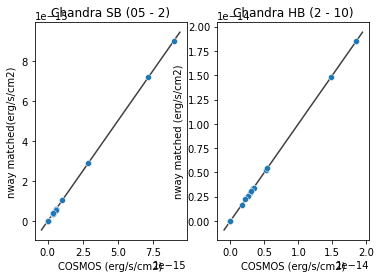

In [31]:
#try plotting 
fig, (ax1,ax2) = plt.subplots(1,2)
#first shrink the dataframe to only those rows where I have tractor photometry while testing
merged_small = merged[(merged.CHANDRA_HB_FLUX >= 0) ] 

sns.scatterplot(data = merged_small, x = "CHANDRA_HB_FLUX", y = "flux_chandra_2_10", ax = ax2)#, robust = True)#scatterplot
#add a diagonal line with y = x
lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax2.set(xlabel = 'COSMOS (erg/s/cm2)', ylabel = 'nway matched (erg/s/cm2)', title = 'Chandra HB (2 - 10)')


sns.scatterplot(data = merged_small, x = "CHANDRA_SB_FLUX", y = "flux_chandra_05_2", ax = ax1)#, robust = True)#scatterplot
#add a diagonal line with y = x
lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax1.set(xlabel = 'COSMOS (erg/s/cm2)', ylabel = 'nway matched(erg/s/cm2)', title = 'Chandra SB (05 - 2)')




In [32]:
merged_small[['CHANDRA_SB_FLUX','flux_chandra_05_2','CHANDRA_HB_FLUX', 'flux_chandra_2_10']]


,CHANDRA_SB_FLUX,flux_chandra_05_2,CHANDRA_HB_FLUX,flux_chandra_2_10
6,4.030000e-16,4.030000e-16,0.000000e+00,0.000000e+00
31,5.920000e-16,5.920000e-16,0.000000e+00,0.000000e+00
72,0.000000e+00,0.000000e+00,2.890000e-15,2.890000e-15
76,7.160000e-15,7.160000e-15,1.480000e-14,1.480000e-14
127,0.000000e+00,0.000000e+00,3.350000e-15,3.350000e-15
137,0.000000e+00,0.000000e+00,3.410000e-15,3.410000e-15
236,0.000000e+00,0.000000e+00,2.520000e-15,2.520000e-15
246,4.860000e-16,4.860000e-16,0.000000e+00,0.000000e+00
247,2.900000e-15,2.900000e-15,5.230000e-15,5.230000e-15
272,8.970000e-15,8.970000e-15,1.850000e-14,1.850000e-14


### Ok, so there are 3 cases where COSMOS found a match and nway did not.  Understanding the nuances of nway would probably help figure out what is happening with these sources

## Make some population plots

[Text(0.5, 0, 'log F5.8/F3.6'), Text(0, 0.5, 'log F8.0/F4.5')]

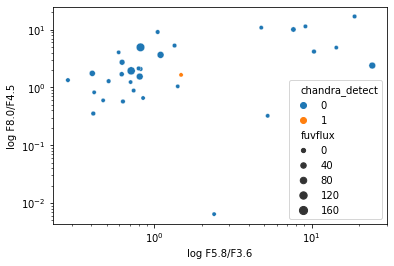

In [35]:
#IRAC color color plots
#overplot galex sources
#overplot xray sources

#make a new column which is a bool of existing chandra measurements
merged['chandra_detect'] = 0
merged.loc[merged.CHANDRA_FLUX > 0,'chandra_detect']=1

#negative Galex fluxes are causing problems
merged.loc[merged.fuvflux < 0, 'fuvflux'] = 0
merged.loc[merged.nuvflux < 0, 'nuvflux'] = 0

fig, ax = plt.subplots()
merged['F5.8divF3.6'] = merged.ch3flux / merged.ch1flux
merged['F8.0divF4.5'] = merged.ch4flux / merged.ch2flux

merged_allirac = merged[(merged['F8.0divF4.5'] > 0) & (merged['F5.8divF3.6'] > 0)]

sns.scatterplot(data = merged_allirac, x = 'F5.8divF3.6', y = 'F8.0divF4.5',
                hue = 'chandra_detect', size = 'fuvflux', ax = ax)

ax.set(xscale="log", yscale="log")
#ax.set_ylim([0.1, 100])
#ax.set_xlim([0.1, 100])

ax.set(xlabel = 'log F5.8/F3.6', ylabel = 'log F8.0/F4.5')



In [36]:
merged_allirac.fuvflux

0             NaN
2        8.278584
3             NaN
4             NaN
9      154.100917
11       0.000000
14            NaN
17            NaN
20            NaN
23      48.530254
29      92.574278
31            NaN
35            NaN
41            NaN
42       0.000000
50       4.058351
54            NaN
55            NaN
56     180.570022
58      22.315791
59            NaN
65       9.215056
66      97.253848
67       8.623718
68            NaN
72       0.000000
73       7.156543
74      91.864092
84       7.140453
88       2.994775
90      12.982276
92            NaN
93      10.341324
97      12.633136
98            NaN
103           NaN
104           NaN
105      0.000000
109      4.295120
110      0.000000
111           NaN
112     60.667519
114      0.000000
116      6.344644
117           NaN
123      2.037232
127           NaN
139           NaN
140           NaN
142           NaN
147           NaN
154           NaN
161      0.000000
162      8.099223
164     31.161949
182       